In [1]:
from Game import *

Version:  0.3.15


Four functions to do:

1. `initial_state()`   return the state for the start of the game
2. `valid_moves(state,player)` return a list of valid moves
3. `update_state(state, player, move )` return the new state
4. `win_status(state,player)` returns one of `"win"`,`"lose"`,`"stalemate"` or `None`

In [2]:
def initial_state():
    return Board(3,3)

In [3]:
def valid_moves(state,player):
    
    moves=[]
    
    for location in range(9): 
        if state[location]==0:
            moves.append(location)
       
    return moves
    

In [4]:
def update_state(state,player,move):
    new_state=state
    new_state[move]=player
        
    return new_state

In [5]:
def win_status(state,player):
    # 0  1  2 
    # 3  4  5 
    # 6  7  8 

    if player==1:
        other_player=2
    else:
        other_player=1
    
    if state[0]==state[1]==state[2]==player:
        return "win"
    if state[3]==state[4]==state[5]==player:
        return "win"
    if state[6]==state[7]==state[8]==player:
        return "win"
    if state[0]==state[3]==state[6]==player:
        return "win"
    if state[1]==state[4]==state[7]==player:
        return "win"
    if state[2]==state[5]==state[8]==player:
        return "win"
    if state[0]==state[4]==state[8]==player:
        return "win"
    if state[6]==state[4]==state[2]==player:
        return "win"
    
    if not valid_moves(state,other_player):
        return "stalemate"
    
    return None

In [6]:
def human_move(state,player):
    print("Locations:")
    state.show_locations()
    print("Valid Moves:")
    print(valid_moves(state,player))
    
    while True:
        move=eval(input("Enter your move"))

        if move not in valid_moves(state,player):
            print("That is not a valid move")
        else:
            break
    
    return move

human_agent=Agent(human_move)

In [7]:
def show_state(state,player):
    print(state)

In [8]:
def random_move(state,player):
    return random.choice(valid_moves(state,player))
random_agent=Agent(random_move)

In [9]:
from Game.minimax import *
def minimax_move(state,player):
    values,actions=minimax_values(state,player,display=False)
    return top_choice(actions,values)
minimax_agent=Agent(minimax_move)

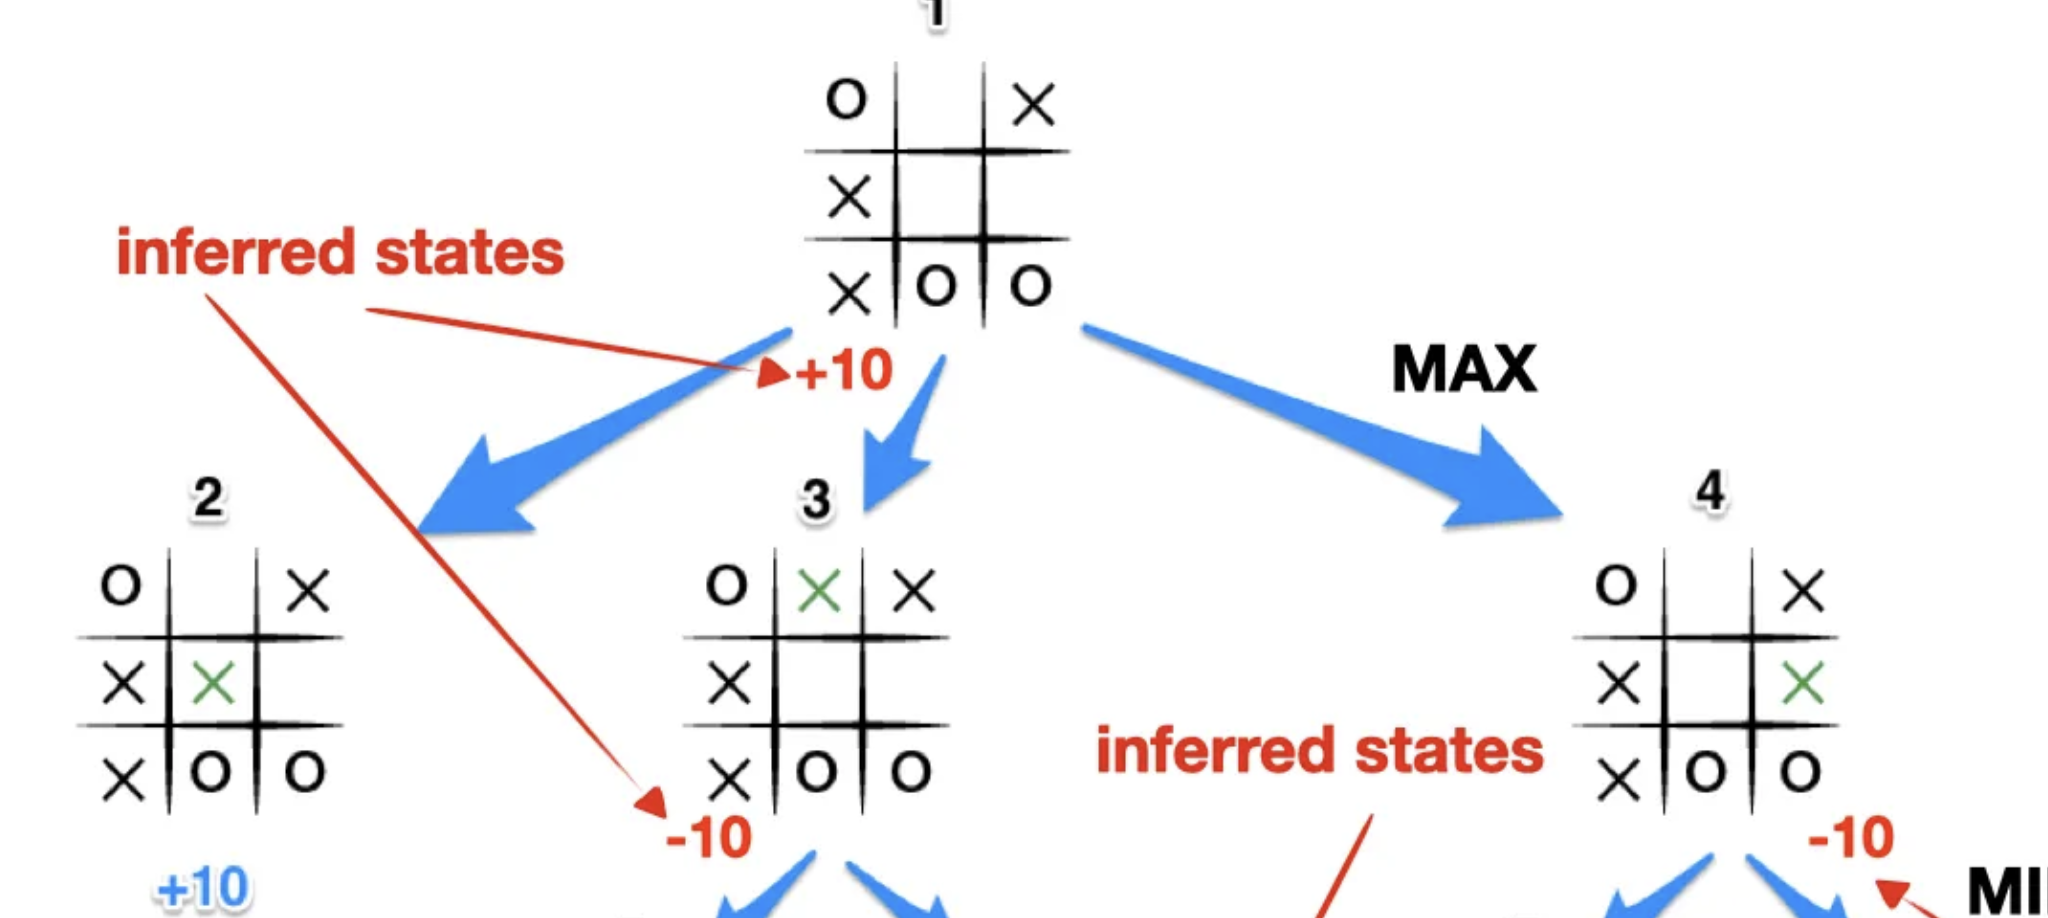

In [10]:
state=Board(3,3)
for loc in [0,7,8]:
    state[loc]=2
for loc in [2,3,6]:
    state[loc]=1
state

 2  0  1 
 1  0  0 
 1  2  2 

In [11]:
minimax_values(state,player=1)

  Choice Time: 0.0002880096435546875 seconds 


([1, -1, -1], [4, 1, 5])

In [12]:
g=Game()
g.run(minimax_agent,random_agent)

====
Game  1
 0  0  0 
 0  0  0 
 0  0  0 

Player 1 moves 4
 0  0  0 
 0  1  0 
 0  0  0 

Player 2 moves 2
 0  0  2 
 0  1  0 
 0  0  0 

Player 1 moves 5
 0  0  2 
 0  1  1 
 0  0  0 

Player 2 moves 0
 2  0  2 
 0  1  1 
 0  0  0 

Player 1 moves 3
 2  0  2 
 1  1  1 
 0  0  0 

Player  1 won.


[1]

## Skittle Agent

In [13]:
def skittles_move(state,player,info):
    T=info.T   # table for the skittles
    learning=info.learning
    last_state=info.last_state
    last_action=info.last_action
    

    # if we haven't seen this state before, initialize it
    if state not in T:
        actions=valid_moves(state,player)
        T[state]=Table()
        for action in actions:
            T[state][action]=2  # start with 1 skittle for each action

    move=weighted_choice(T[state])

    if move is None:
        move=random_move(state,player)

        if learning:
            if last_state:
                T[last_state][last_action]-=1  # punish last action == remove one skittle
                if T[last_state][last_action]<0:
                    T[last_state][last_action]=0  # don't go below zero
    
    return move


def skittles_after(status,player,info):
    T=info.T   # table for the skittles
    learning=info.learning
    last_state=info.last_state
    last_action=info.last_action

    if learning:
        if status=='lose':
            T[last_state][last_action]-=1  # punish last action == remove one skittle
            if T[last_state][last_action]<0:
                T[last_state][last_action]=0  # don't go below zero


In [14]:
skittles_agent=Agent(skittles_move)
skittles_agent.T=Table()  # starts off empty
skittles_agent.post=skittles_after
skittles_agent.learning=True

## Running the Game

In [22]:
g=Game()
g.display=False
g.save_states=True
g.run(minimax_agent,skittles_agent)
len(g.games[0]['states'])

6

In [21]:
len(g.games[0]['states'])

8

In [18]:
len(g.games['states'])

TypeError: list indices must be integers or slices, not str

In [18]:
skittles_agent.T

{(0, 0, 1, 0, 0, 0, 0, 0, 0): {0: 2, 1: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2},
 (0, 0, 1, 2, 0, 0, 0, 0, 1): {0: 2, 1: 2, 4: 2, 5: 2, 6: 2, 7: 2},
 (0, 0, 1, 2, 1, 2, 0, 0, 1): {0: 2, 1: 2, 6: 2, 7: 2},
 (0, 1, 1, 2, 1, 2, 0, 2, 1): {0: 1, 6: 2}}

# Stages of training

- training stage == learning, changing # of skittles
- testing stage == fixed # of skittles, see how well it does
- epoch -- number of training games before testing


In [49]:
iteration_count=0
percentage_won_player1=[]
percentage_won_player2=[]
percentage_stalemate=[]
number_of_iterations=[]

In [50]:
agent1=Agent(skittles_move)
agent1.T=Table()  # starts off empty
agent1.post=skittles_after
agent1.learning=True

agent2=Agent(skittles_move)
agent2.T=Table()  # starts off empty
agent2.post=skittles_after
agent2.learning=True

In [51]:
epoch_number=200  # play 200 games, learning, and then test
N_test=100  # play 100 games, fixed skittles, see how well it does
N_train=5000  # play 500 epochs, learning, changing skittles

total_number_of_games=epoch_number*N_train
total_number_of_games

1000000

In [52]:
from tqdm.notebook import tqdm
from IPython.display import display,clear_output

In [53]:
from matplotlib import pyplot as plt

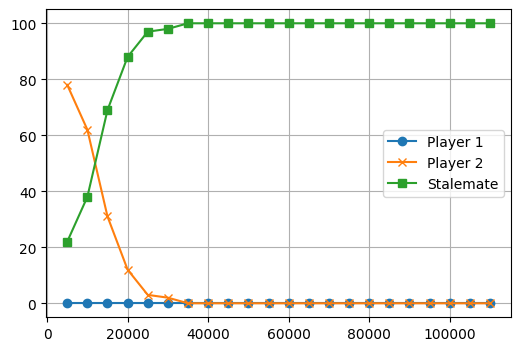

KeyboardInterrupt: 

In [54]:
plt.close('all')
fig, ax = plt.subplots(figsize=(6, 4))
#plt.show(block=False)
for i in tqdm(range(epoch_number), desc="Updating plot", leave=True):
    # training step
    agent1.learning=True
    agent2.learning=True

    g=Game(number_of_games=N_train)
    g.display=False
    result=g.run(agent1,agent2)

    # testing step
    agent1.learning=False
    agent2.learning=False

    g=Game(number_of_games=N_test)
    g.display=False
    result=g.run(agent1,minimax_agent)

    iteration_count+=N_train


    percentage_won_player1.append(result.count(1)/N_test*100)
    percentage_won_player2.append(result.count(2)/N_test*100)
    percentage_stalemate.append(result.count(0)/N_test*100)
    number_of_iterations.append(iteration_count)

    clear_output(wait=True)
    ax.cla()
    ax.grid(True)
    
    ax.plot(number_of_iterations,percentage_won_player1,'-o',label="Player 1")
    ax.plot(number_of_iterations,percentage_won_player2,'-x',label="Player 2")
    ax.plot(number_of_iterations,percentage_stalemate,'-s',label="Stalemate")
    ax.legend()

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.show()
    display(fig)